# Chapter 9: Recurrent Neural Networks

### Dhuvi karthikeyan

02/25/2023

First we looked at tabular data for regression and classification with an MLP:

    * Tabular data is where the number of rows corresponds with the number of examples and each example has a fixed number of attributes. 
    
Then we looked at image data, which was still of fixed dimensions but less tabular. Image data was also processed one at a time in a vacuum. The convolutional models we studied didn't have the capability to process images in a sequential manner like in a video stream.

Recurrent Neural Networks (RNNs) **capture dynamics of sequences via recurrent connections.**

Lipton et al 2015, A critical review of recurrent neural networks for sequence learning.

## 9.1 Working with Sequences

Shifting from our previous examples in which we had a list of vectors per example, we must now work with an ordered list of vectors where each vector reqpresents a feature of our feature indexed by time step. 

Another distinction is that our previous models assumed that individual inputs were independently sampled from the same underlying distribution. Here documents might be sampled from different distributions entirely, and words in a document might not be independent from each other. 

Types of Sequence Problems:
* Sequence to fixed target:
    * Sentiment analysis on text
* Fixed target to sequence:
    * Image captioning
* Sequence to Sequence:
    * Aligned: Video captioning
        * Means step by step correspondence
    * Unaligned: Machine translation
    
Sequence modeling, unsupervised density modeling, given a collection of sequences, predict probability of a particular sequence p(x1, x2, ..., xT)

### 9.1.1 Autoregressive Models

$$ P(x_t | x_{t-1}, ..., x_2, x_1) $$

Since it may be tough to learn the entire distribution it may sometimes suffice to learn statistics of the distribution like the mean and variance.

* Conditional Expectation $\mathbb{E}[(x_t | x_{t-1}, ..., x_2, x_1)]$
* Conditional Variance $Var(x_t | x_{t-1}, ..., x_2, x_1)$

Models that regress values based on previous values are called **autoregressive models.** Note, the number of inputs depends on the timestep of sampling with later timesteps having more inputs (There are ways of dealing with this).

**Latent autoregressive models** maintain some summary of the past observations in a collative hidden state $h_t$.

$$P(x_t|h_t)$$


### 9.1.2 Sequence Models

$$ P(x_1, ..., x_T) = P(x_1)\prod_{t=2}^T P(x_t|x_{t-1, ..., x_1} $$

#### Markov Models

Condition only on a window of k is the same as a model having an inductive bias the process of data generation is a k-th order Markov process.

#### Decoding Order

Decoding in order has the strong inductive bias of locality in the sequence. This is true for most sequences with causality. This means that future tokens don't impact past tokens but the converse may be true. Hence the left right decoding. 

### 9.1.3 Training

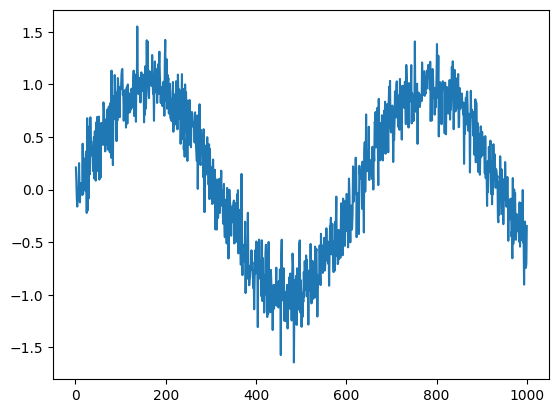

In [66]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

k = 4
T = 1000
t = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(.01*t) + torch.randn(T) * 0.2

plt.plot(t, x)

In [20]:
X = torch.stack([x[i : T-k+i] for i in range(k)], 1) #feature matrix
# X = torch.stack([x[i : i+k] for i in range(T-k)]) inefficient but intuitive
y = x[k:].reshape((-1,1))

len(X) == len(y)

True

In [28]:
class LinearRegression(nn.Module):
    """
    Implements a Linear Regression Model in Torch
    """
    def __init__(
      self,
      input_dim,
      output_dim,
      bias  
    ):
        super(LinearRegression, self).__init__()
        self.net = nn.Linear(input_dim, output_dim, bias)
        
    def forward(self, X):
        y = self.net(X)
        return y

In [29]:
def train_epochs(n_epochs, inputs, labels, model, optimizer, criterion):
    dset = [(i,o) for i,o in zip(inputs, labels)]
    for e in range(n_epochs):
        running_loss = 0.0
        for inputs,label in dset:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, label)
            running_loss += loss
            loss.backward()
            optimizer.step()
        print("The average loss for epoch {} is {}".format(e, running_loss/len(dset)))
    return model

In [46]:
lr = LinearRegression(4, 1, bias=False)
optimizer = torch.optim.SGD(lr.parameters(), lr=0.01, momentum=0.9)
criterion =  nn.MSELoss()

opt_model = train_epochs(10, X[:600], y[:600], lr, optimizer, criterion)

The average loss for epoch 0 is 0.05977450683712959
The average loss for epoch 1 is 0.058314550668001175
The average loss for epoch 2 is 0.05831816419959068
The average loss for epoch 3 is 0.05831819027662277
The average loss for epoch 4 is 0.05831819400191307
The average loss for epoch 5 is 0.05831819400191307
The average loss for epoch 6 is 0.05831819400191307
The average loss for epoch 7 is 0.05831819027662277
The average loss for epoch 8 is 0.05831819400191307
The average loss for epoch 9 is 0.05831819400191307


### 9.1.4 Prediction

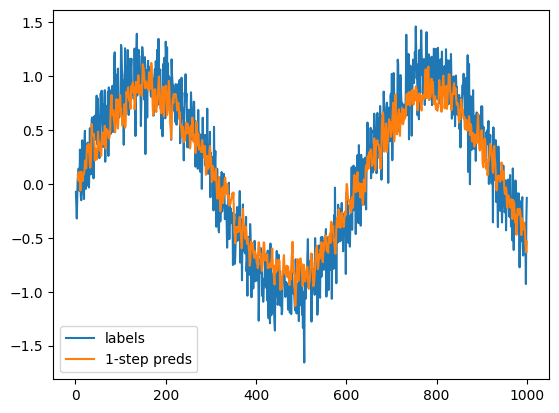

In [47]:
x_hat = lr(X).detach().numpy()
plt.plot(t, x)
plt.plot(t[k:], x_hat)
plt.legend(['labels', '1-step preds'])

In [55]:
def n_step_pred(n, T, k, model, x):
    features = []
    for i in range(k):
        features.append(x[i : i+T-k-n+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(n):
        preds = model(torch.stack(features[i : i+k], 1))
        features.append(preds.reshape(-1))
    return features[k:]


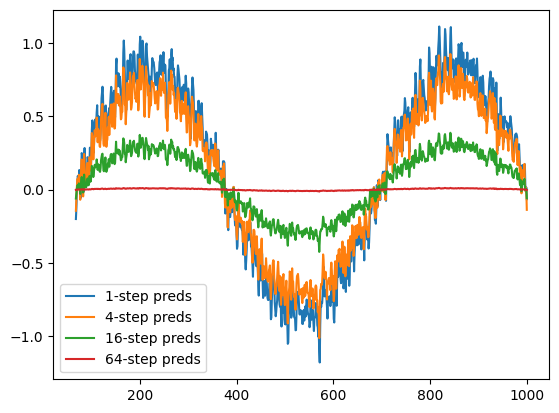

In [65]:
steps = (1, 4, 16, 64)
preds = n_step_pred(steps[-1], T, k, opt_model, x)

plt.plot(t[k+steps[-1]-1:], preds[1-1].detach().numpy())
plt.plot(t[k+steps[-1]-1:], preds[4-1].detach().numpy())
plt.plot(t[k+steps[-1]-1:], preds[16-1].detach().numpy())
plt.plot(t[k+steps[-1]-1:], preds[64-1].detach().numpy())
plt.legend([f'{k}-step preds' for k in steps])

## 9.2 Converting Raw Text into Sequence Data

### 9.2.2 Tokenization

Tokens are atomic, in that they are indivisible, and they are what comprise all sequences. The tokenization of scheme is usually not arbitrary as word-level tokenization and character-level tokenization often have different implications.

### 9.2.3 Vocabulary 

Maps tokens to indices. Often times the least frequent tokens are dropped and replaced with an < unk > token.

### 9.2.5 Exploratory Language Statistics

Zipf’s law: 

$$n_i \propto \frac{1}{i^\alpha}  \text{  where $\alpha$ is a constant}$$

**Zipf's law holds true for bi-grams and tri-grams with smaller $\alpha$**

## 9.3 Language Models

Language models seek to learn the joint probability of a sequence given a collection or corpus of sequences.

### 9.3.1 Learning Language Models

$$ P(x_1, x_2, ..., x_T) = \prod_{t=1}^T P(x_t | x_1, ..., x_{t-1}) $$

Laplace smoothing for rare word frequencies. 

### 9.3.2 Perplexity

A method in which we can assess how surprising/random the text is:

Cross entropy loss averaged over all n tokens of a sequence 

$$ \frac{1}{n} = \sum_{t=1}^n -logP(x_t|x_{t-1}, ..., x1)$$

Perpexlity is the exponentiation of the inverse of the above. It is roughly equal to the geometric mean of the number of choices in terms of next token, aka equal to rolling a ? sided die. Perplexity is from 1, $\infty$ with lower equals better. Baseline perplexity is the number of tokens in the vocabulary.

#### Class Notes:

p(x_t | x_{t-1}, ..., x_1_

Frame this as a |V|-way classification problem

1. Predict O_t
2. Apply softmax
3. Use cross-entropy loss with the "label" as the actual next token

## 9.4 Recurrent Neural Networks

Number of parameters is equal to $|V|^n$ for n-order markov process.

### 9.4.2 RNN with Hidden States

With no hidden states:

$$ H_t = \phi(X_tW_{xh} + b_h)$$
$$ O_t = H_tW_{hq}+b_q$$

With hidden states:

$$ H_t = \phi(X_tW_{xh} + H_{t-1}W_hh + b_h)$$
$$ O_t = H_tW_{hq}+b_q$$

RNN Algorithm:
1. Concatenate input $X_t$ and $H_{t-1}$
2. Feed concatenation to a FC layer with $\phi$ to get $H_t$
3. Feed $H_t$ forward to the next time step and to another FC layer to get O

### 9.4.3 RNN-based Character-Level Language Models

Bengio et al. 2003 proposed using a neural network for language modeling

## 9.5 Recurrent Neural Network Implementation From Scratch

In [90]:
class RNNScratch(nn.Module):  
    """
    The RNN model implemented from scratch.
    Takes in inputs of dimension (num_steps, bsz, input_dim)
    """
    def __init__(self, 
                 num_inputs, 
                 num_hiddens, 
                 sigma=0.01
                ):
        super(RNNScratch, self).__init__()
        self.scale = sigma
        self.hidden_dim = num_hiddens
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)  # Scale down Std Normal
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)  # Scale down Std Normal
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))
        
    def forward(self, inputs, hidden=None):
        if hidden is None:
            # Initialize the hidden_state with (bsz, num_hiddens)
            hidden = torch.zeros((inputs.shape[1], self.hidden_dim), device=inputs.device)
        
        else:
            hidden, = hidden
            
        outputs = []
        for X in inputs:
            hidden = torch.tanh(torch.matmul(X, self.W_xh) +
                                torch.matmul(hidden, self.W_hh) + self.b_h)
            outputs.append(hidden)
        return outputs, hidden

Although we take sample mini-batches of teh shape (batch_size, num_steps, vocab_size) we transpose this to (num_steps, batch_size, and vocab_size) for puposes of easier looping over the outermost dimension for updating hidden states by each timestep.

In [91]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, hidden = rnn(X)
assert len(outputs) == num_steps 
assert outputs[0].shape == (batch_size, num_hiddens)  # First timestep has (bsz,hidden)
assert hidden.shape == (batch_size, num_hiddens)

### 9.5.3 Gradient Clipping

Backpropagation not only happens through the layers but also through the timesteps resulting in a chain of matrix products of length O(T) for T timesteps.

* Chain of matrix products = Exploding or Vanishing gradients

Special architectures helped mitigate the vanishing gradient problem (residual connections help mitigate this), but exploding gradients are still finnicky.

#### Lipschitz Continuity

"In mathematical analysis, Lipschitz continuity, named after German mathematician Rudolf Lipschitz, is a strong form of uniform continuity for functions. Intuitively, a Lipschitz continuous function is limited in how fast it can change: there exists a real number such that, for every pair of points on the graph of this function, the absolute value of the slope of the line connecting them is not greater than this real number; the smallest such bound is called the Lipschitz constant of the function" - Wikipedia

$$ \frac{|f(x) - f(y)|}{||x-y||} \leq L$$

When we update a function using the gradient update rule the change in the loss function is bounded by:

$$ \frac{|f(x) - f(x-\eta g)|}{||x-(x-\eta g)||} \leq L $$
$$ |f(x) - f(x-\eta g)| \leq L||x-(x-\eta g)|| $$
$$ |f(x) - f(x-\eta g)| \leq L||\eta g|| $$
$$ |f(x) - f(x-\eta g)| \leq L\eta|| g|| $$

This is the double-edged of sword of taking slow gradient steps which can take longer to converge but also less chance of divergence.

**Exploding** gradients concretely means that ||g|| has grown too larger. 

Gradient clipping projects gradients onto a ball of given maximum radius $\theta$:

$$ g \leftarrow min(1, \frac{\theta}{||g||})g$$

It ensures that the direction is the same, just the magnitude is clipped above a certain value.

In [ ]:
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

### 9.5.5 Decoding 

Auto-regressive decoder where the user-provided prefix is given to a model and the model must decode the next token given context according to some order. There are times where LEFT-right decoding is done and also times where random decoding is done. 

**Warm-up Period:** in the warm-up period, the tokens of the subsequence are fed through the model and the hidden states are updated until decoding time where the hidden state at decoding has all the prefix embedded in it.

## 9.7 Backpropagation Through Time

Backpropagation through a RNN requires the RNN to be unrolled across timesteps. 

### 9.7.1 Analysis of Gradients in RNNs

Define:
* $h_t = f(x_t, h_{t-1}, w_h$
* $o_t = g(h_t, w_o)$
* $L(x_1,...,x_T,y_1,...y_T, w_h, w_o) = \frac{1}{T}\sum^T_{t=1}l(y_t, o_t)$


$$ \frac{\partial L}{\partial w_h} = \frac{1}{T} \sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial w_h}$$
$$ = \frac{}{} \sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial o_t} \frac{\partial g(h_t, w_o)}{\partial h_t} \frac{\partial h_t}{\partial w_h}$$

$$ \frac{\partial h_t}{\partial w_h} = \frac{\partial f(x_t, h_{t-1}, w_h)}{\partial w_h} + \frac{\partial f(x_t, h_{t-1}, w_h)}{\partial h_{t-1}}\frac{\partial h_{t-1}}{\partial w_h}$$

The above, due to the recurrence in h, has an implicit recursive call to the parameters which can be expressed according to the following recurrence relation:

Define
* $a_t = \frac{\partial h_t}{\partial w_h}$
* $b_t = \frac{\partial f(x_t, h_{t-1}, w_h)}{\partial w_h}$
* $c_t = \frac{\partial f(x_t, h_{t-1}, w_h)}{\partial h_{t-1}}$

Setting $a_0 = 0$:

$$ a_t = b_t + \sum_{i=1}^{t-1}(\prod_{j=i+1}^t c_j)b_i$$

$$ \frac{\partial h_t}{\partial w_h} = \frac{\partial f(x_t, h_{t-1}, w_h)}{\partial w_h} + \sum_{i=1}^{t-1}(\prod_{j=i+1}^t \frac{\partial f(x_j, h_{j-1}, w_h)}{\partial h_{j-1}})\frac{\partial f(x_i, h_{i-1}, w_h)}{\partial w_h}$$

While this alleviates the issue of computing gradients recursively, it still poses the issue of numerical stability when handling chain of matrix products that grow at an order of number of steps. There are a number of strategies to deal with this which will be discussed below

#### Full Computation 

Rarely used because the computation is very slow and susceptible to exploding or vanishing gradients. 

#### Truncating Time Steps

Terminating sum at $ \frac{\partial h_{t-\tau}}{\partial w_h} $ by setting it equal to 1. This places a window of influence.

#### Randomized Truncation 

Replace $\frac{\partial h_t}{\partial w_h}$ with a random variable that is correct in expectation but truncates the sequence.

Predefine $ 0 \leq \pi_t \leq 1$ for a specific sequence of $ \zeta_t $

#### Comparing Strategies

Randomized truncation doesn't work that much better than regular truncation in practice. 


### 9.7.2 Backpropagation Through Time in Detail

Define:
* $x_t \in \mathbb{R}^d $ 
* $y_t \in \mathbb{R}^1 $ 
* $h_t \in \mathbb{R}^h $ 
* $o_t \in \mathbb{R}^q $ 

$ h_t = W_{hx}x_t + W_{hh}h_{t-1}$
$ o_t = W_{qh}h_{t}$

$ L = \frac{1}{T}\sum_{t=1}^T l(o_t, y_t)$

#### Accounting

$$ \frac{\partial L}{\partial o_t} = \frac{\partial l(o_t, y_t)}{T * \partial o_t}  \in \mathbb{R}^q$$

$$ \frac{\partial L}{\partial W_{qh}} \in \mathbb{R}^{qxh}$$
$$ \frac{\partial L}{\partial W_{qh}} = \sum_{t=1}^T \text{prod}(\frac{\partial L}{\partial o_t}, \frac{\partial o_t}{\partial W_{qh}}) = \sum^T_{t=1} \frac{\partial L}{\partial o_t}h^T_t$$

$$ \frac{\partial L}{\partial h_T} \in \mathbb{R}^h$$
$$ \frac{\partial L}{\partial h_T} = \text{prod}(\frac{\partial L}{\partial o_T}, \frac{\partial o_T}{\partial h_T}) = W^T_{qh}\frac{\partial L}{\partial o_T}$$

$$ \frac{\partial L}{\partial h_t} = \text{prod}(\frac{\partial L}{\partial h_{t+1}}, \frac{\partial h_{t+1}}{\partial h_t}) + \text{prod}(\frac{\partial L}{\partial o_t}, \frac{\partial o_t}{\partial h_t}) = W^T_{hh}\frac{\partial L}{\partial h_{t+1}} + W^T_{qh}\frac{\partial L}{\partial o_t}$$
$$ = \sum^T_{i=t}(W^T_{hh})^{T-i}W^T_{qh}\frac{\partial L}{\partial o_{T+t-i}}$$


Numerical stability is largely governed by $\frac{\partial L}{\partial h_t}$

We can see that the above where $W_hh$ is raised to a large power meaning that if the eigenvalues of this matrix are below one they will tend to zero and above one tends to infinity which is the vandishing and exploding gradients issue we must be aware of.

$$ \frac{\partial L}{\partial W_{hx}} = \sum^T_{t=1}\text{prod}(\frac{\partial L}{\partial h_t}, \frac{\partial h_t}{\partial W_{hx}}) = \sum^T_{t=1} \frac{\partial L}{\partial h_T}x^T_t$$

$$ \frac{\partial L}{\partial W_{hh}} = \sum^T_{t=1}\text{prod}(\frac{\partial L}{\partial h_t}, \frac{\partial h_t}{\partial W_{hh}}) = \sum^T_{t=1} \frac{\partial L}{\partial h_T}h^T_{t-1}$$

## Class Notes 02/27/23

Out of vocabulary text: < UNK > 

Time delay neural network (The first pass idea for the sequence based neural network)
* NNs require fixed length inputs
* Take the last n-elements of a sequence and feed them into MLP


### Questions:

1. Why doesn't the field use binary encoding of vocabulary IDs? Although it would require matrix multiplication is would be a log2(V) matrix and might come with the benefit that gradients are shared much more than per word basis.


